In this notebook, I have implemented multiclass classification using a neural network.

1. Number of hidden layers = 2
2. Number of nodes in each layer:
    - input layer: 2
    - first hidden layer: 5
    - second hidden layer: 5
    - output layer: 3
3. Activation functions:
    - hidden layers: tanh
    - output layer: softmax
4. Number of epochs: 1000
5. Optimizer: Stochastic Gradient Descent with Momentum
6. Learning rate: 0.001
7. I have shown results for beta = 0.8 and beta = 0.9

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv('train3class.csv')
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,x1,x2,label
0,-1.49674,0.36394,1.0
1,2.54235,4.34709,1.0
2,4.67471,-13.11690,2.0
3,-6.04984,0.57434,2.0
4,-10.52298,5.15198,0.0


Let us check the classes in the dataset, and how many examples belong to each class

In [3]:
df['label'].value_counts()

0.0    151
2.0    150
1.0    150
Name: label, dtype: int64

Split the data into training and test sets: 80% training, 20% test

In [4]:
X = np.array(df[['x1', 'x2']])
y = np.array(df['label'])

X_train = X[:int(df.shape[0]*0.8), :]
X_test = X[int(df.shape[0]*0.8):, :]
y_train = y[:int(df.shape[0]*0.8)]
y_test = y[int(df.shape[0]*0.8):]

# Convert the training labels into one-hot vectors.
temp = np.zeros((y_train.shape[0], 3))
for i in range(len(temp)):
    temp[i][int(y_train[i])] = 1
y_train_one_hot = temp

temp1 = np.zeros((y_test.shape[0], 3))
for i in range(len(temp1)):
    temp1[i][int(y_test[i])] = 1
y_test_one_hot = temp1

### Visualization of the dataset

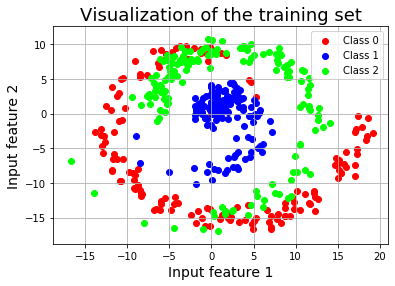

In [5]:
def plot_training_set():
    class_0 = np.array(df.loc[df['label'] == 0.0])
    class_1 = np.array(df.loc[df['label'] == 1.0])
    class_2 = np.array(df.loc[df['label'] == 2.0])

    plt.scatter(class_0[:, 0], class_0[:, 1], color='red', label='Class 0')
    plt.scatter(class_1[:, 0], class_1[:, 1], color='blue', label='Class 1')
    plt.scatter(class_2[:, 0], class_2[:, 1], color='lime', label='Class 2')
    plt.title("Visualization of the training set", size=18)
    plt.xlabel("Input feature 1", size=14)
    plt.ylabel("Input feature 2", size=14)
    plt.legend()
    plt.grid()
    
    
plot_training_set()
plt.show()

### No. of nodes in the Input and Output Layers

In [6]:
input_nodes = X_train.shape[1]
output_nodes = y_train_one_hot.shape[1]

### Activation functions and their Derivatives

In [7]:
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    # x is the tanh value
    return (1 - (np.tanh(x)**2))

def sigmoid(x):
    return 1.0/(1+ np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1.0 - sigmoid(x))

def softmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)

### Loss function and its derivative

In [8]:
def crossentropyloss(y, y_hat):
    """Categorical cross-entropy loss for multiclass classification"""
    return -np.sum(y.reshape(y_hat.shape) * np.log(y_hat))

def crossentropyloss_derivative(y, y_hat):
    """Derivative of the cross entropy loss"""
    return -np.divide(y, y_hat)

### Initialization

In [9]:
def initialize_parameters(layer_dims):
    np.random.seed(42)
    parameters = {}
    previous_updates = {}
    for i in range(1, len(layer_dims)):
        W = np.random.rand(layer_dims[i], layer_dims[i-1])*0.01
        b = np.zeros((layer_dims[i], 1))
        parameters["W"+str(i)] = W
        parameters["b"+str(i)] = b
        previous_updates["W"+str(i)] = np.zeros((layer_dims[i], layer_dims[i-1]))
        previous_updates["b"+str(i)] = np.zeros((layer_dims[i], 1))
    
    return parameters, previous_updates

### Forward Propagation

In [10]:
def forward_propagation(X, parameters):
    L = len(layer_dims)
    A = [None]*L
    Z = [None]*L
    A[0] = X.reshape((2, 1))
    
    for l in range(1, L):
        W = parameters["W"+str(l)]
        b = parameters["b"+str(l)]
        Z[l] = np.dot(W, A[l-1]) + b
        if l == L-1:
            A[l] = softmax(Z[l])
        else:
            A[l] = tanh(Z[l])
            
    output = A[L-1]
            
    return output, A, Z 

### Backpropagation

In [11]:
def backprop(y_hat, y, A, Z, parameters):
    gradients = {}
    L = len(layer_dims) - 1
    y = y.reshape(y_hat.shape)
    dWL = np.dot((y_hat - y), A[L-1].T)
    dbL = y_hat - y
    dZL = y_hat - y
    dAL = -np.divide(y, y_hat)
    
    gradients["dA"+str(L)] = dAL
    gradients["dW"+str(L)] = dWL
    gradients["db"+str(L)] = dbL
    gradients["dZ"+str(L)] = dZL
    
    for l in reversed(range(1, L)):
        gradients["dA"+str(l)] = np.dot(parameters["W"+str(l+1)].T, gradients["dZ"+str(l+1)])
        gradients["dZ"+str(l)] = gradients["dA"+str(l)] * tanh_derivative(Z[l])
        gradients["dW"+str(l)] = np.dot(gradients["dZ"+str(l)], A[l-1].T)
        gradients["db"+str(l)] = gradients["dZ"+str(l)]
        
    return gradients

### Parameter Update

In [18]:
def update_parameters_with_momentum(parameters, grads, learning_rate, beta, previous_updates):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L + 1):
        previous_updates["W"+str(l)] = beta*previous_updates["W"+str(l)] + (1-beta)*grads["dW" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*previous_updates["W"+str(l)]
        
        previous_updates["b"+str(l)] = beta*previous_updates["b"+str(l)] + (1-beta)*grads["db" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*previous_updates["b"+str(l)]

    return parameters, previous_updates

### Plotting cost curve

In [13]:
def plot_cost_curve(train_costs, val_costs):
    plt.plot(list(range(len(train_costs))), train_costs, 'r', label="Training loss")
    plt.plot(list(range(len(val_costs))), val_costs, 'lime', label="Validation loss")
    plt.title("Training Loss vs Number of Epochs", size=18)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

### Building the Model

In [22]:
def NN_model(X_train, y_train, X_test, y_test, layer_dims, learning_rate=0.001, beta=0.9,max_epochs=500):
    parameters, previous_updates = initialize_parameters(layer_dims)
    
    epoch_cost = [] # average training cost at the end of every epoch
    
    prev_epoch_cost = 1000 # some large initial value
    curr_epoch_cost = 0
    
    validation_epoch_cost = [] # average validation cost at the end of every epoch
    
    count=1 # keeps track of the number of epochs
    # An epoch is one complete pass through the training data
    
    while abs(prev_epoch_cost-curr_epoch_cost) > 1e-7 and count<=max_epochs:
        costs = []# training costs
        val_costs = []# validation costs
        count+=1# increment the number of epochs
        for i in range(len(X_train)):
            output, A, Z = forward_propagation(X_train[i], parameters)
            cost = crossentropyloss(y_train[i], output)
            gradients = backprop(output, y_train[i], A, Z, parameters)
            parameters, previous_updates = update_parameters_with_momentum(
                                                                parameters, gradients, learning_rate, beta,
                                                                previous_updates)
            costs.append(cost)
            
        # vaidation part (these examples do not contribute to parameter update)
        # therefore, the 'model' has still not seen these examples.
        for j in range(len(X_test)):
            out, _, _ = forward_propagation(X_test[j], parameters)
            cost = crossentropyloss(y_test[j], out)
            val_costs.append(cost)
            
        # average training loss for one epoch
        curr_epoch_cost = sum(costs)/len(X_train)
        if len(epoch_cost) >= 1:
            prev_epoch_cost = epoch_cost[-1]
        epoch_cost.append(curr_epoch_cost)
        
        # average validation loss for one epoch
        validation_epoch_cost.append(sum(val_costs)/len(X_test))
        
    plot_cost_curve(epoch_cost, validation_epoch_cost)
    return parameters, epoch_cost

### Predictions and Accuracy

In [16]:
def predict(X, parameters):
    # X here is one training example
    pred, _, _ = forward_propagation(X, parameters)
    return pred

def predictions(X, parameters):
    # X is an array of many training examples
    y_pred = np.zeros(len(X))
    for i in range(len(X)):
        y_pred[i] = np.argmax(predict(X[i], parameters))
    return y_pred
        
def model_accuracy(predictions, y_truth):
    return np.mean(predictions == y_truth)*100

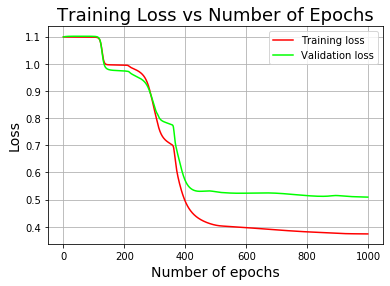

In [23]:
layer_dims = [input_nodes, 5, 5, output_nodes]
parameters, epoch_cost = NN_model(X_train, y_train_one_hot, X_test, y_test_one_hot, layer_dims, learning_rate=0.001, max_epochs=1000)

The wavy nature of the loss curves is because we are using SGD for the optimization step. We can make the loss curves smoother and increase the rate of convergence by using SGD along with momentum in the weight update step.

In [24]:
y_pred_train = predictions(X_train, parameters)
print("Training accuracy = {}%".format(round(model_accuracy(y_pred_train,y_train), 3)))

y_pred_test = predictions(X_test, parameters)
print("Test accuracy = {}%".format(round(model_accuracy(y_pred_test, y_test), 3)))

Training accuracy = 85.833%
Test accuracy = 83.516%


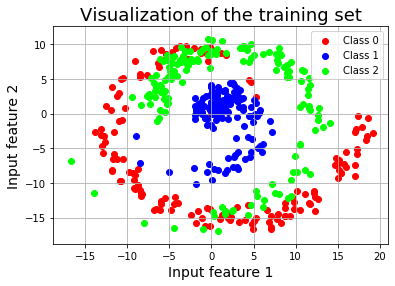

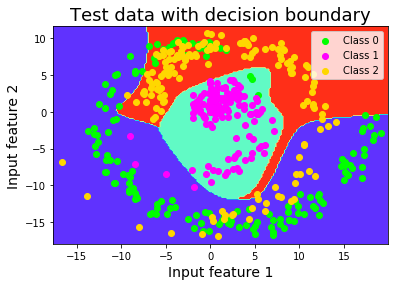

In [25]:
plot_training_set()
plt.show()


h = .2  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = predictions(np.c_[xx.ravel(), yy.ravel()], parameters)

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow)

class_0 = np.array(df.loc[df['label'] == 0.0])
class_1 = np.array(df.loc[df['label'] == 1.0])
class_2 = np.array(df.loc[df['label'] == 2.0])

plt.scatter(class_0[:, 0], class_0[:, 1], color='lime', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='magenta', label='Class 1')
plt.scatter(class_2[:, 0], class_2[:, 1], color='gold', label='Class 2')

plt.title("Test data with decision boundary", size=18)
plt.xlabel("Input feature 1", size=14)
plt.ylabel("Input feature 2", size=14)
plt.legend()
plt.show()

#### For Beta = 0.8

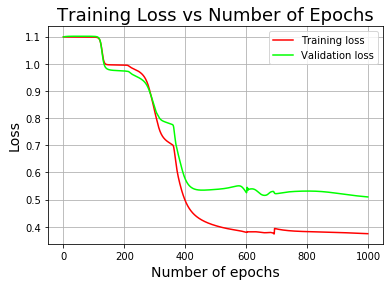

In [26]:
parameters, epoch_cost = NN_model(X_train, y_train_one_hot, X_test, y_test_one_hot, layer_dims, learning_rate=0.001, beta=0.8, max_epochs=1000)

In [27]:
y_pred_train = predictions(X_train, parameters)
print("Training accuracy = {}%".format(round(model_accuracy(y_pred_train,y_train), 3)))

y_pred_test = predictions(X_test, parameters)
print("Test accuracy = {}%".format(round(model_accuracy(y_pred_test, y_test), 3)))

Training accuracy = 86.389%
Test accuracy = 83.516%


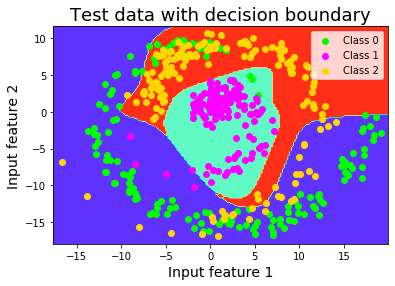

In [28]:
h = .2  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = predictions(np.c_[xx.ravel(), yy.ravel()], parameters)

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow)

class_0 = np.array(df.loc[df['label'] == 0.0])
class_1 = np.array(df.loc[df['label'] == 1.0])
class_2 = np.array(df.loc[df['label'] == 2.0])

plt.scatter(class_0[:, 0], class_0[:, 1], color='lime', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='magenta', label='Class 1')
plt.scatter(class_2[:, 0], class_2[:, 1], color='gold', label='Class 2')

plt.title("Test data with decision boundary", size=18)
plt.xlabel("Input feature 1", size=14)
plt.ylabel("Input feature 2", size=14)
plt.legend()
plt.show()